# Absolute and relative cavity entry phases

There are three ways to define the phase of a cavity: by its relative entry phase $\phi_{0,\,\mathrm{rel}}$, its absolute entry phase $\phi_{0,\,\mathrm{abs}}$ or its synchronous phase $\phi_s$ (still under implementation).

The relation between relative and entry phases is:
\begin{equation}
E_0\cos{\phi_{0,\,\mathrm{abs}}} = E_0\cos{(\phi_{0,\,\mathrm{rel}} + \phi_\mathrm{in})}
\end{equation}
where $\phi_\mathrm{in}$ is the phase at which the synchronous particle enters the cavity, $E_0$ is the amplitude of the electric field.

## Preparation

### Load libraries

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from lightwin.config_manager import process_config
from lightwin.beam_calculation.beam_calculator import BeamCalculator
from lightwin.beam_calculation.factory import BeamCalculatorsFactory
from lightwin.beam_calculation.simulation_output.simulation_output import SimulationOutput
from lightwin.core.accelerator.accelerator import Accelerator
from lightwin.core.accelerator.factory import NoFault, WithFaults
from lightwin.failures.fault_scenario import FaultScenario, fault_scenario_factory
from lightwin.visualization import plot
from lightwin.constants import example_config, example_results

plt.rcParams["figure.figsize"] = (15, 5)

/home/placais/LightWin/venv/lib/python3.12/site-packages/pymoo/core/decision_making.py:2: DeprecationWarning: Please import `cKDTree` from the `scipy.spatial` namespace; the `scipy.spatial.ckdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.ckdtree import cKDTree


### Set configuration dicts

In [2]:
CONFIG_KEYS = {
    'files': 'files',
    'beam_calculator': 'generic_envelope1d',
    'beam': 'beam',
    'plots': 'plots_minimal',
    'wtf': 'generic_wtf',
    'design_space': 'generic_design_space',
}

override = {'beam_calculator': {'flag_phi_abs': True}, 'plots': {'energy': False}}
config_abs = process_config(example_config, CONFIG_KEYS, warn_mismatch=True, override=override)
plots_phase = config_abs['plots']

[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/data/example/results_tests')
Setting log_file = 'lightwin.log'


In [3]:
override = {
    'beam_calculator':
        {
            'flag_phi_abs': False
        },
    'plots': {
        'cav': True
    },
    'wtf': {
        'objective_preset': 'rephased_ADS',
    }
}
config_rel = process_config(example_config, CONFIG_KEYS, warn_mismatch=True, override=override)
plots_complete = config_rel['plots']

[INFO    ] [table_spec.py       ] .toml table [files] loaded!
[INFO    ] [table_spec.py       ] .toml table [beam] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_envelope1d] loaded!
[INFO    ] [table_spec.py       ] .toml table [plots_minimal] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_design_space] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_wtf] loaded!
[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/data/example/results_tests')
Setting log_file = 'lightwin.log'


/home/placais/LightWin/src/lightwin/util/log_manager.py:67: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/placais/LightWin/data/example/results_tests/lightwin.log' mode='a' encoding='UTF-8'>
  del logging.root.handlers[:]


### Set BeamCalculator objects

In [4]:
factory = BeamCalculatorsFactory(**config_abs)
solver_abs = factory.run_all()[0]

factory = BeamCalculatorsFactory(**config_rel)
solver_rel = factory.run_all()[0]

### Set Accelerator objects

In [5]:
factory = WithFaults(beam_calculators=solver_abs, **config_abs)
accelerators_abs = factory.run_all()
for acc in accelerators_abs:
    acc.name += r' (absolute $\phi_0$)'
working_abs = accelerators_abs[0]
broken_abs = accelerators_abs[1]

factory = WithFaults(beam_calculators=solver_rel, **config_rel)
accelerators_rel = factory.run_all()
for acc in accelerators_rel:
    acc.name += r' (relative $\phi_0$)'
working_rel = accelerators_rel[0]
broken_rel = accelerators_rel[1]

working = (working_abs, working_rel)
broken = (broken_abs, broken_rel)

[INFO    ] [factory.py          ] First initialisation of ListOfElements, ecompassing all linac. Created with dat_file = PosixPath('/home/placais/LightWin/data/example/example.dat')
[INFO    ] [list_of_elements.py ] Successfully created a ListOfElements with self.w_kin_in = 20.0 MeV and self.phi_abs_in = 0.0 rad.
[WARNING ] [factory.py          ] You asked LW a simulation in absolute phase, while there is at least one cavity in relative phase in the .dat file used by TW. You can expect a phase difference between LightWin results and TraceWin results for the same input .dat, after the first failed cavity. No difference should appear with the output .dat, or when using TraceWin solver within LightWin.
[INFO    ] [factory.py          ] First initialisation of ListOfElements, ecompassing all linac. Created with dat_file = PosixPath('/home/placais/LightWin/data/example/example.dat')
[INFO    ] [list_of_elements.py ] Successfully created a ListOfElements with self.w_kin_in = 20.0 MeV and sel

## Propagate the beam

### Nominal linac

In [6]:
_ = solver_abs.compute(working_abs)
_ = solver_rel.compute(working_rel)
figs = plot.factory(working, plots_phase, save_fig=False, clean_fig=False)

[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000000_ref/0_Envelope1D/example.dat.
[INFO    ] [beam_calculator.py  ] Elapsed time in beam calculation: 0:00:01.733981
[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000000_ref/0_Envelope1D/example.dat.
[INFO    ] [beam_calculator.py  ] Elapsed time in beam calculation: 0:00:01.679793


<div class="alert alert-info">
The reference $\phi_0$ that is used is the one defined in the `.dat`.
As a matter of a fact, we need to propagate the beam a first time to know the entry phase of the synchronous particle in every cavity.
This quantity is necessary to link $\phi_{0,\,\mathrm{abs}}$ with $\phi_{0,\,\mathrm{rel}}$.
</div>

## Linac with one broken cavity

In [7]:
fault_scenarios_abs = fault_scenario_factory(accelerators_abs, solver_abs, config_abs['wtf'], config_abs['design_space'])

[INFO    ] [design_space.py     ] Created variables:
Variable                  | Element         | x_0      | Lower lim | Upper lim
----------------------------------------------------------------------------------------------------
$\phi_{0, abs}$ [deg]     | FM10            |   55.649 |  -360.000 |   360.000
$\phi_{0, abs}$ [deg]     | FM12            |  101.288 |  -360.000 |   360.000
$\phi_{0, abs}$ [deg]     | FM9             |  272.279 |  -360.000 |   360.000
$k_e$ [1]                 | FM10            |    1.649 |     1.319 |     4.756
$k_e$ [1]                 | FM12            |    1.698 |     1.359 |     4.756
$k_e$ [1]                 | FM9             |    1.649 |     1.319 |     4.756
Created constraints:

Constraint                | Element         | x_0      | Lower lim | Upper lim
----------------------------------------------------------------------------------------------------
[INFO    ] [factory.py          ] Created variables:
Variable                  | Element   

In [8]:
fault_scenarios_rel = fault_scenario_factory(accelerators_rel, solver_rel, config_rel['wtf'], config_rel['design_space'])

[INFO    ] [design_space.py     ] Created variables:
Variable                  | Element         | x_0      | Lower lim | Upper lim
----------------------------------------------------------------------------------------------------
$\phi_{0, abs}$ [deg]     | FM10            |   55.649 |  -360.000 |   360.000
$\phi_{0, abs}$ [deg]     | FM12            |  101.288 |  -360.000 |   360.000
$\phi_{0, abs}$ [deg]     | FM9             |  272.279 |  -360.000 |   360.000
$k_e$ [1]                 | FM10            |    1.649 |     1.319 |     4.756
$k_e$ [1]                 | FM12            |    1.698 |     1.359 |     4.756
$k_e$ [1]                 | FM9             |    1.649 |     1.319 |     4.756
Created constraints:

Constraint                | Element         | x_0      | Lower lim | Upper lim
----------------------------------------------------------------------------------------------------
[INFO    ] [factory.py          ] Created variables:
Variable                  | Element   

In [9]:
_ = solver_abs.compute(broken_abs)
figs = plot.factory(accelerators_abs, plots_phase, save_fig=False, clean_fig=False)

[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/0_Envelope1D/example.dat.
[INFO    ] [beam_calculator.py  ] Elapsed time in beam calculation: 0:00:01.673947


In [10]:
_ = solver_rel.compute(broken_rel)
figs = plot.factory(accelerators_rel, plots_phase, save_fig=False, clean_fig=False)

[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/0_Envelope1D/example.dat.
[INFO    ] [beam_calculator.py  ] Elapsed time in beam calculation: 0:00:01.679380


<div class="alert alert-info">
    After a cavity failure, the definition of the reference $\phi_0$ becomes important.
    With $\phi_\mathrm{ref} = \phi_{0,\,\mathrm{abs}}$, the cavities after the failure keep their absolute entry phase.
    With $\phi_\mathrm{ref} = \phi_{0,\,\mathrm{rel}}$, the cavities after the failure (olive color) are rephased, so that they keep their relative entry phase.
</div>

## Fixing the fault

In the absolute phase calculation, it is mandatory to retrieve the nominal energy and the nominal phase of the beam at the exit of the compensation zone.
In the relative phase calculation, the phase no longer needs to be retrieved, as the integrity of the linac after the failure is rephased.

[INFO    ] [downhill_simplex.py ] Objective functions results:
0:                                     | 3.525559733930095e-06
1:                                     | 2.8023950449096446e-06
2:                                     | 8.57188357339389e-06
Norm: 9.682983911019546e-06
[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/0_Envelope1D/example.dat.
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/tmp/tmp.dat.
[INFO    ] [debug.py            ] Fixed (1 of 1)
----------------------------------------------------------------------------------------------------
   name           status       k_e phi_0_abs phi_0_rel  v_cav_mv     phi_s
1   FM9  compensate (ok)  1.396623  5.304986  3.839113  0.613335 -0.186859
2  FM10  compensate (ok)  2.174922  0.823152  3.169552  0.971894 -0.924121
3  FM12  compensate (ok)  2

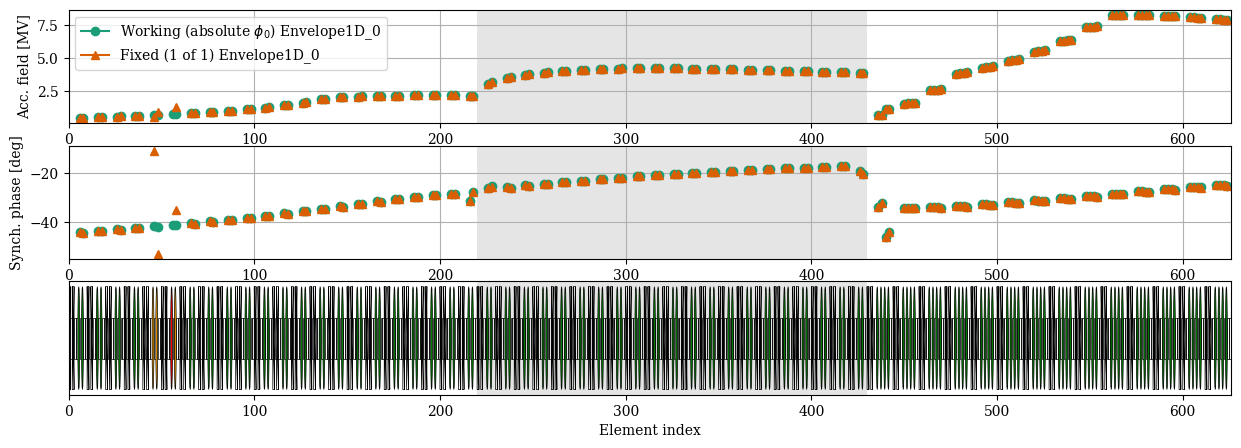

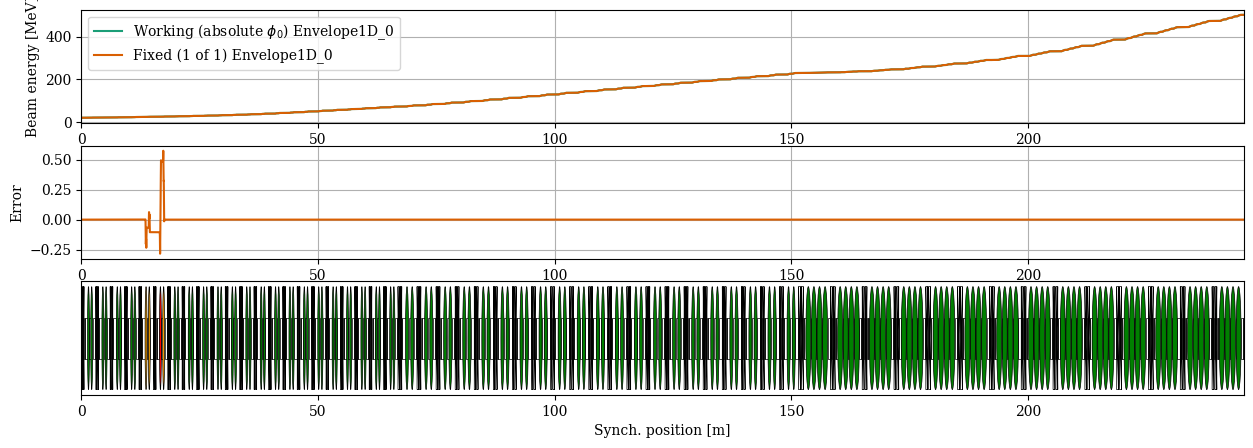

In [11]:
for scenario in fault_scenarios_abs:
    scenario.fix_all()
figs = plot.factory(accelerators_abs, plots_complete, save_fig=False, clean_fig=False)

[INFO    ] [downhill_simplex.py ] Objective functions results:
0:                                     | -3.0456890556251892e-06
1:                                     | 1.3755391933711891e-05
Norm: 1.4088542475131387e-05
[WARNING ] [simulation_output.py] data_in_tw_fashion is bugged
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/0_Envelope1D/example.dat.
[INFO    ] [dat_files.py        ] New dat saved in /home/placais/LightWin/data/example/results_tests/000001/tmp/tmp.dat.
[INFO    ] [debug.py            ] Fixed (1 of 1)
----------------------------------------------------------------------------------------------------
   name           status       k_e phi_0_abs phi_0_rel  v_cav_mv     phi_s
1   FM9  compensate (ok)  1.573024  5.464923  3.999051  0.693787 -0.030682
2  FM10  compensate (ok)   1.70301  0.549345  2.862516  0.758889  -1.24041
3  FM12  compensate (ok)  3.035455  1.742644   3.82891  1.412413 -0.330618
-----------

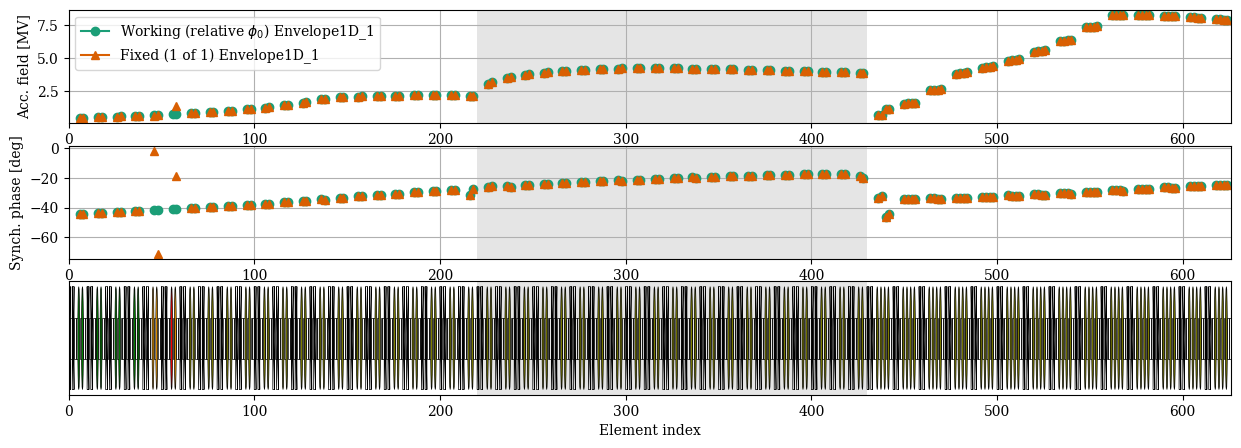

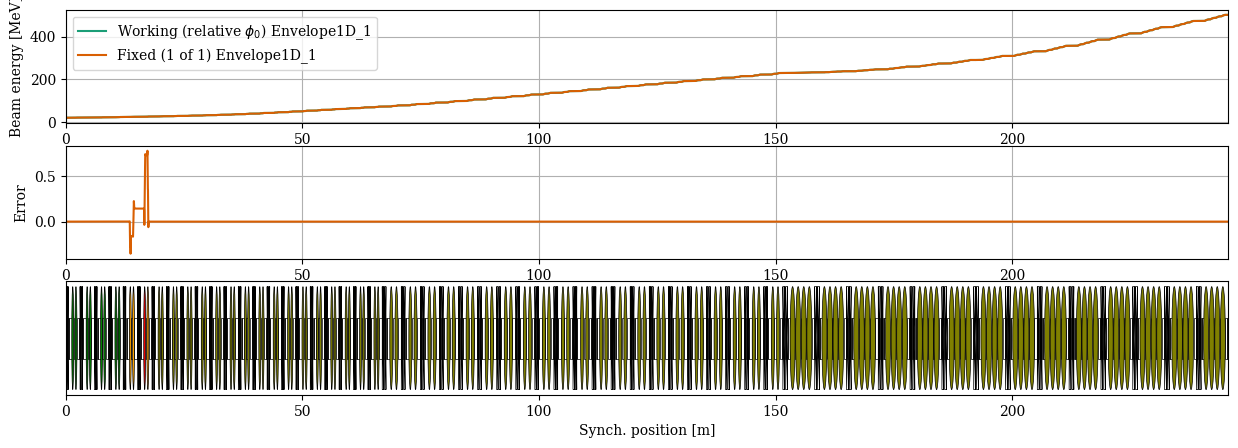

In [12]:
for scenario in fault_scenarios_rel:
    scenario.fix_all()
figs = plot.factory(accelerators_rel, plots_complete, save_fig=False, clean_fig=False)

The main advantage with the studies in relative phase is that we do not need to recover the absolute beam phase at the exit of the compensation zone.
It is one less variable for the optimisation objective.